# 1 - Introduction

## 1.1 - Dependencies

### 1.1.1 - External libraries

In [1]:

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import SimpleITK as sitk
import torch
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import torchviz
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd
import math

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, GeneralizedWassersteinDiceLoss, GeneralizedDiceLoss
from monai.transforms import (
    SpatialCrop
)

### 1.1.2 - Local libraries

In [2]:
%reload_ext autoreload
%autoreload 2
import pylib.nifti as nii
from pylib import visualization
from pylib.models import unet
from pylib.datasets import dataset, star
from pylib.datasets.lazy_dataset import LazyDataset
import pylib.imaging.transforms as transforms
import pylib.imaging.lesion_tools as lt
from pylib.evaluation import evaluation
from config import *
import os

# 2 - Data visualization

The following data was kindly provided by Penn state University: 

* Central line of PRLs
* Preprocessed* FLAIR image
* Preprocessed* T2*-PHASE image
* Preprocessed*T1 image
* Segmentation mask of all lesions


*and was preprocessed with the following steps by Lou et al. (2021):

* Phase unwrapping of T2*-images.
* N4 inhomogeneity correction.
* Registration of T1 and FLAIR images to phase space.
* Skullstripping.
* WhiteStripe normalization. 

In [3]:
EXAMPLE_PATIENT_ID = "001"
example_idx = 96

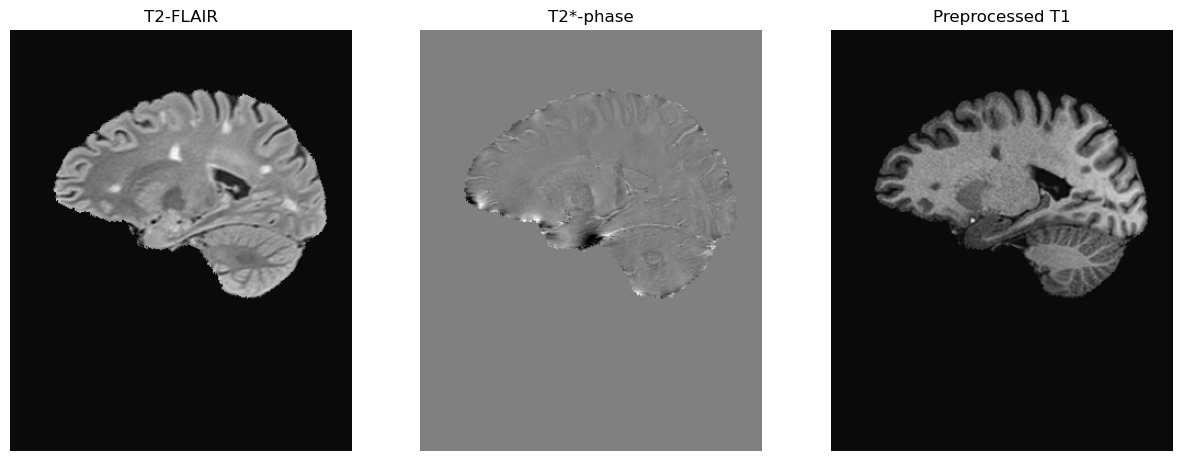

In [4]:
plt.close('all')
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 10))
visualization.plot_nifti_on_ax(axs[0], img = f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}/{FLAIR}", title = "T2-FLAIR", k_rot90=2, idx=example_idx)
visualization.plot_nifti_on_ax(axs[1], img = f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}/{PHASE}", title = "T2*-phase", k_rot90=2, idx=example_idx)
visualization.plot_nifti_on_ax(axs[2], img = f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}/{T1}", title = "Preprocessed T1", k_rot90=2, idx=example_idx)
plt.show()

# 3 - Preprocessing

## 3.1 - Dataset analyzation


In [5]:
train_dataset = torch.load(PATH_VISUALIZATION_DATASET, weights_only=False)

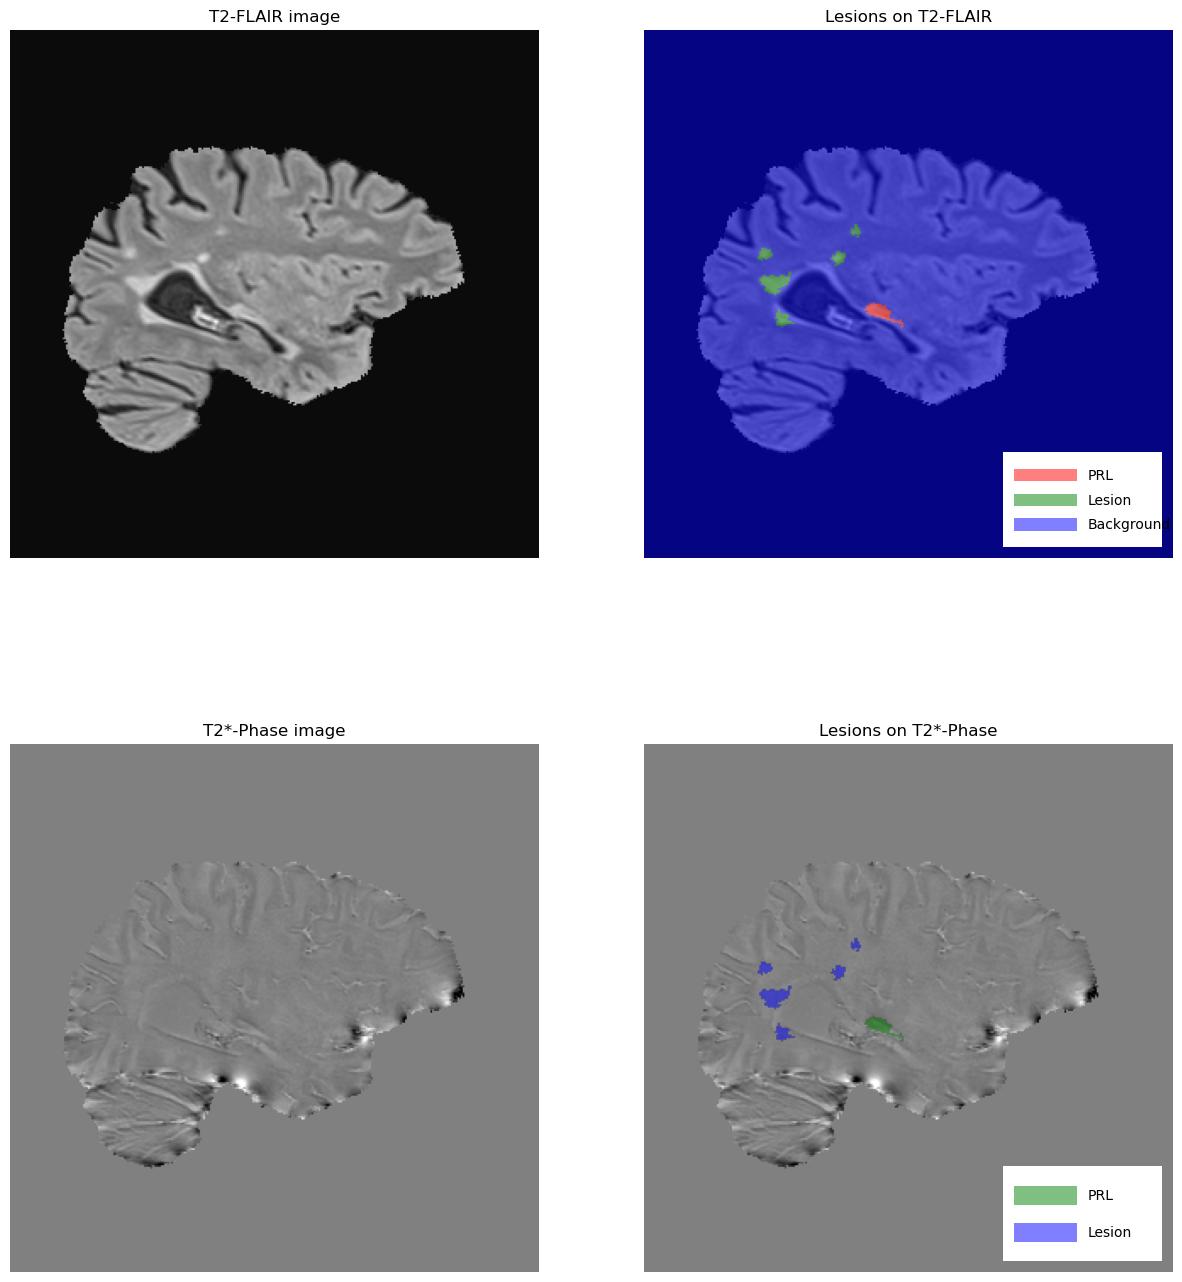

In [6]:
EXAMPLE_TRAIN_IDX = 11
img, label = train_dataset[EXAMPLE_TRAIN_IDX]

plt.close('all')
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 17))
visualization.plot_nifti_on_ax(axs[0][0], img = img[CHANNEL_FLAIR], title = "T2-FLAIR image")
visualization.plot_nifti_on_ax(axs[0][1], img = img[CHANNEL_FLAIR], mask=label, title = "Lesions on T2-FLAIR", mask_legend=["Background", "Lesion", "PRL"], drop_first_label_channel=False)
visualization.plot_nifti_on_ax(axs[1][0], img = img[CHANNEL_PHASE], title = "T2*-Phase image")
visualization.plot_nifti_on_ax(axs[1][1], img = img[CHANNEL_PHASE], mask=label, title = "Lesions on T2*-Phase", mask_legend=["Lesion", "PRL"])
plt.show()

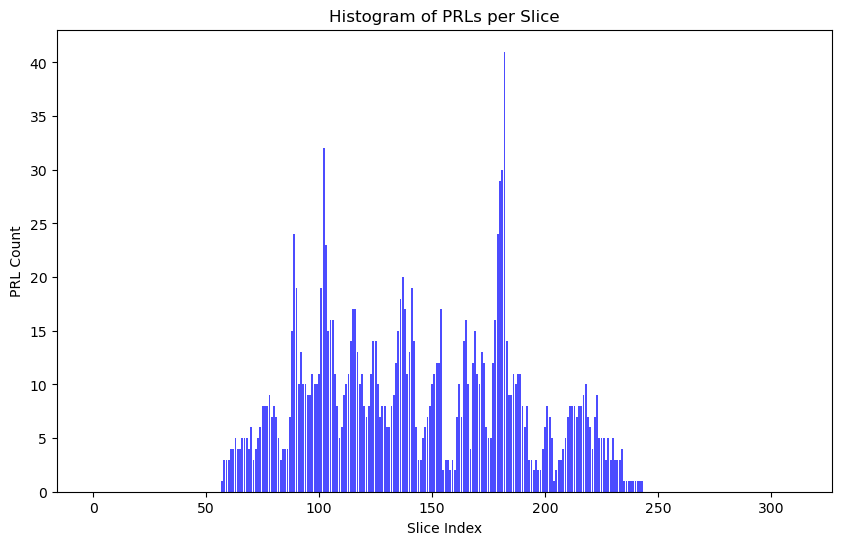

tensor(57) tensor(243)


In [7]:
all_prls = [dataset.process_patient(os.path.join(ORIG_PATH, file), fnames = [PHASE_UNWRAPPED_UBMASK])[0] for file in os.listdir(ORIG_PATH)]
per_z_prls = [torch.sum(prl, dim=(1, 2)).squeeze(0) for prl in all_prls]
per_z_prls = torch.sum(torch.stack(per_z_prls), dim=0)

plt.close('all')
plt.figure(figsize=(10, 6))
plt.bar(range(len(per_z_prls)), per_z_prls.numpy(), color='blue', alpha=0.7)
plt.xlabel('Slice Index')
plt.ylabel('PRL Count')
plt.title('Histogram of PRLs per Slice')
plt.show()

indices = torch.where(per_z_prls > 0)[0]
print(torch.min(indices), torch.max(indices))

# 3.2 - MS-Lesion Segmentation Dataset

In [8]:
CREATE_SEG_DATASET = False
if CREATE_SEG_DATASET:
    dataset.create_lesion_dataset(
        patient_dirs=[os.path.join(ORIG_PATH, p) for p in os.listdir(ORIG_PATH)], 
        flair_fname=FLAIR, 
        phase_fname=PHASE, 
        lesion_fname=SEG_2_PHASE,
        prl_fname=PHASE_UNWRAPPED_UBMASK, 
        save_seg_train_path=PATH_TRAIN_LESION_SEG_DATASET, 
        save_seg_val_path=PATH_VAL_LESION_SEG_DATASET,
        save_seg_test_path=PATH_TEST_LESION_SEG_DATASET,
        num_val=1,
        num_test=1
        )

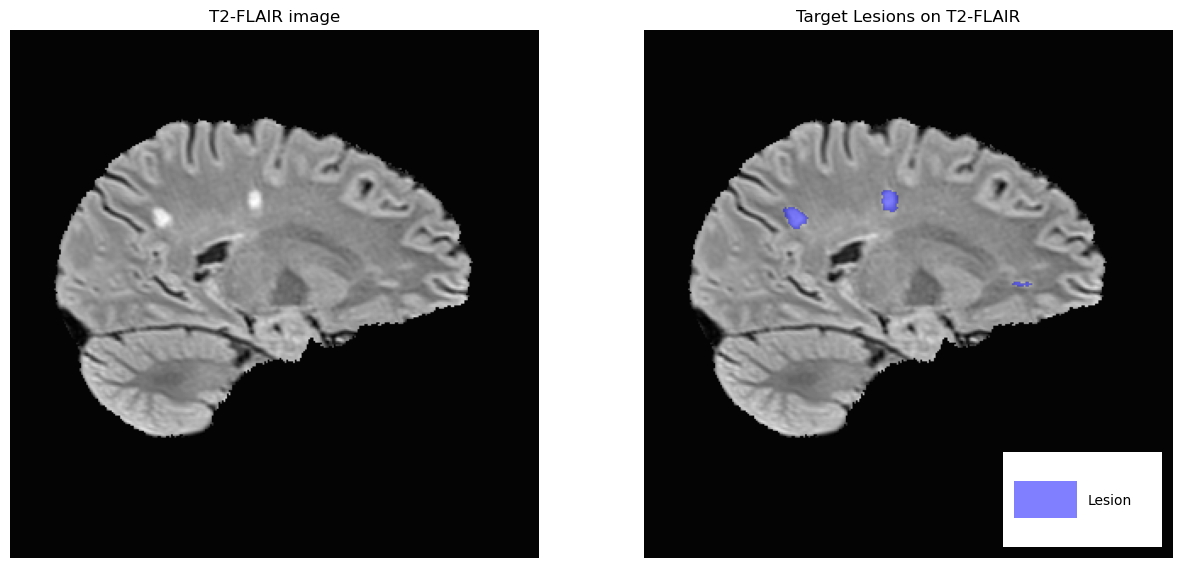

In [9]:
EXAMPLE_TRAIN_IDX = 150
prl_seg_train_dataset = torch.load(PATH_TRAIN_LESION_SEG_DATASET, weights_only=False)
img, label = prl_seg_train_dataset[EXAMPLE_TRAIN_IDX]

plt.close('all')
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 10))
visualization.plot_nifti_on_ax(axs[0], img = img[0], title = "T2-FLAIR image")
visualization.plot_nifti_on_ax(axs[1], img = img[0], mask=label, title = "Target Lesions on T2-FLAIR", mask_legend=["Lesion"], drop_first_label_channel=False)
plt.show()

# 3.3 - PRL Classification Dataset

In [10]:
example_phase, example_lesions, example_prl = dataset.process_patient(f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}", fnames = [PHASE, SEG_2_PHASE, PHASE_UNWRAPPED_UBMASK])

example_phase = example_phase[0]
example_lesions = example_lesions[0]
example_prl = example_prl[0]

imgs, labels = dataset.process_prl_tensors_to_sub_images_2d(
    example_phase, example_lesions, example_prl, 
    img_size=[64, 64],
    lesion_expansion=3,
    min_inter_lesion_distance=MIN_SUB_LESION_DISTANCE,
    mask = True
)

print(imgs[0].shape)


n_cols = 6
n_rows = 2


torch.Size([1, 64, 64])


[82, 86, 88, 90, 93, 95, 98, 100, 103, 105, 108, 111, 115, 137, 138, 141, 146, 153, 160, 164, 168, 173, 178, 179, 182, 183, 186, 187, 190, 191, 195, 199, 206, 213, 220, 221, 227, 228, 235, 319, 323, 326, 332, 337, 341, 345, 349, 352, 354, 355, 357, 358, 360, 361, 363, 365, 366, 368, 369, 371, 372, 375, 378, 381, 384, 387, 389, 393, 403]


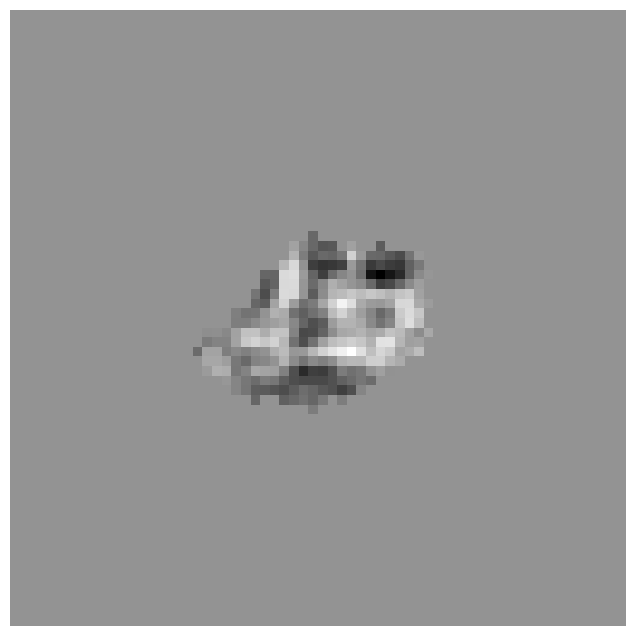

In [11]:
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 8))
prl_indices = [i for i in range(len(imgs)) if labels[i] == 1]
print(prl_indices)
visualization.plot_nifti_on_ax(axs, img = imgs[prl_indices[6]][0])


In [12]:
CREATE_CLASS_DATASET = False
if CREATE_CLASS_DATASET:
    dataset.create_prl_class_dataset_3d(
        patient_dirs = [os.path.join(ORIG_PATH, p) for p in os.listdir(ORIG_PATH)],
        phase_fname=PHASE,
        lesion_fname=SEG_2_PHASE,
        prl_fname=PHASE_UNWRAPPED_UBMASK, 
        img_size=SUB_LESION_IMG_SIZE,
        min_inter_lesion_distance=MIN_SUB_LESION_DISTANCE,
        lesion_expansion=3,
        mask=False,
        save_class_train_path=PATH_3D_TRAIN_PRL_CLASS_DATASET,
        save_class_val_path=PATH_3D_VAL_PRL_CLASS_DATASET,
        save_class_test_path=PATH_3D_TEST_PRL_CLASS_DATASET,
        num_val_samples=1,
        num_test_samples=1
    )

# 3.4 - SWI data

https://pmc.ncbi.nlm.nih.gov/articles/PMC3805391/

Mean of T2*-phase: -1.7871249914169312, Std of T2*-phase: 28.0258731842041, Min: -472.5318603515625, Max: 469.0610046386719
Mean of T2*-phase high-pass filtered: -1.7871249914169312, Std of T2*-phase high-pass filtered: 28.0258731842041, Min: -472.5318603515625, Max: 469.0610046386719


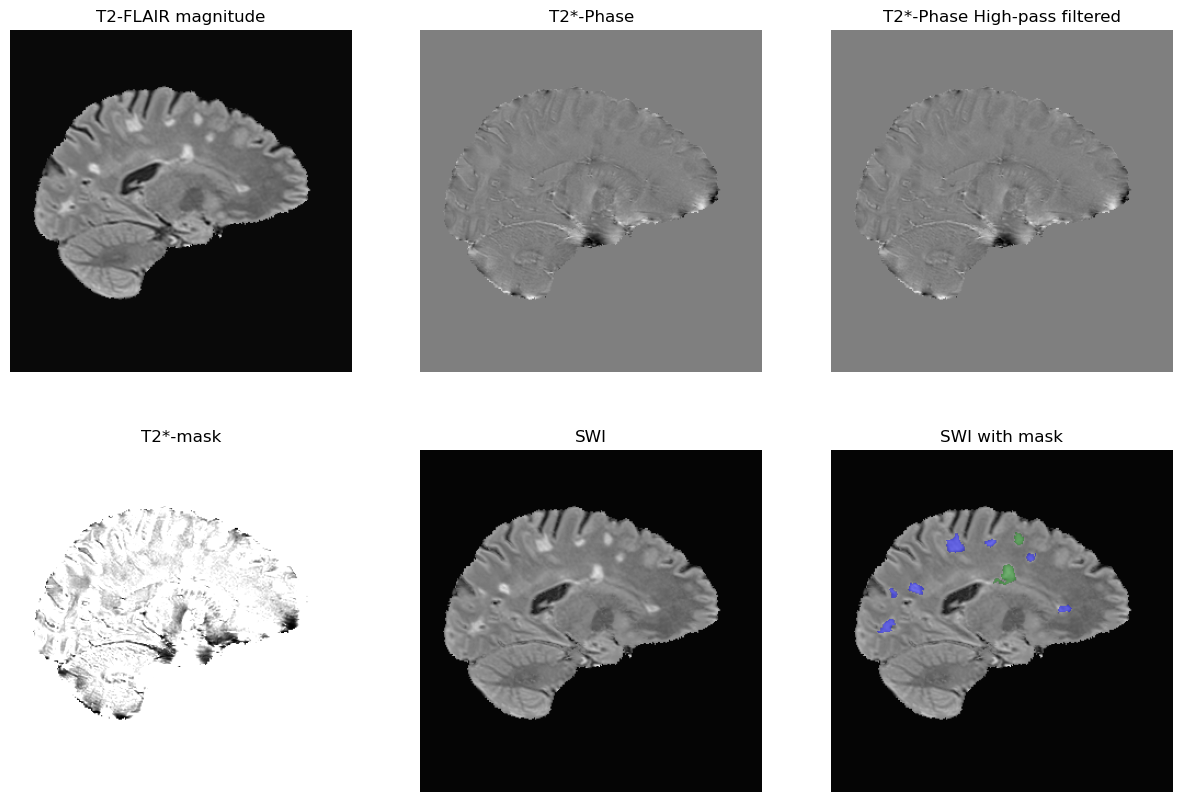

In [13]:

example_idx = 100
phase, mag, mask, prl_mask = dataset.process_patient(f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}", fnames = [PHASE, FLAIR, SEG_2_PHASE, PHASE_UNWRAPPED_UBMASK])


high_pass_phase = phase.clone()


mask[mask > 0] = 1
prl_mask[prl_mask > 0] = 1

mask, prl_mask_growed = lt.grow_all_regions(mask.squeeze(0), prl_mask.clone().squeeze(0))

prl_mask_growed = prl_mask_growed.to(torch.float32)
mask[prl_mask_growed > 0] = 0


mask = torch.stack([mask, prl_mask_growed], dim=0)

#high_pass_phase = high_pass_phase / high_pass_phase.max() * math.pi

## SIEMENS is left-handed, so we are interested in the positive phase
phase_mask = transforms.create_phase_mask(high_pass_phase, n = 4)

flair_s = phase_mask * mag


print(f"Mean of T2*-phase: {torch.mean(phase)}, Std of T2*-phase: {torch.std(phase)}, Min: {torch.min(phase)}, Max: {torch.max(phase)}")
print(f"Mean of T2*-phase high-pass filtered: {torch.mean(high_pass_phase)}, Std of T2*-phase high-pass filtered: {torch.std(high_pass_phase)}, Min: {torch.min(high_pass_phase)}, Max: {torch.max(high_pass_phase)}")

        
phase = phase.squeeze(0)
high_pass_phase = high_pass_phase.squeeze(0)
mag = mag.squeeze(0)
flair_s = flair_s.squeeze(0)
phase_mask = phase_mask.squeeze(0)

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 10))


visualization.plot_nifti_on_ax(axs[0][0], img = mag[example_idx], title = "T2-FLAIR magnitude")
visualization.plot_nifti_on_ax(axs[0][1], img = phase[example_idx], title = "T2*-Phase")
visualization.plot_nifti_on_ax(axs[0][2], img = high_pass_phase[example_idx], title = "T2*-Phase High-pass filtered")
visualization.plot_nifti_on_ax(axs[1][0], img = phase_mask[example_idx], title = "T2*-mask")
visualization.plot_nifti_on_ax(axs[1][1], img = flair_s[example_idx], title = "SWI")
visualization.plot_nifti_on_ax(axs[1][2], img = flair_s[example_idx], mask = mask[:, example_idx], drop_first_label_channel=False, title = "SWI with mask")
fig.savefig("output/images/flair_star.png")

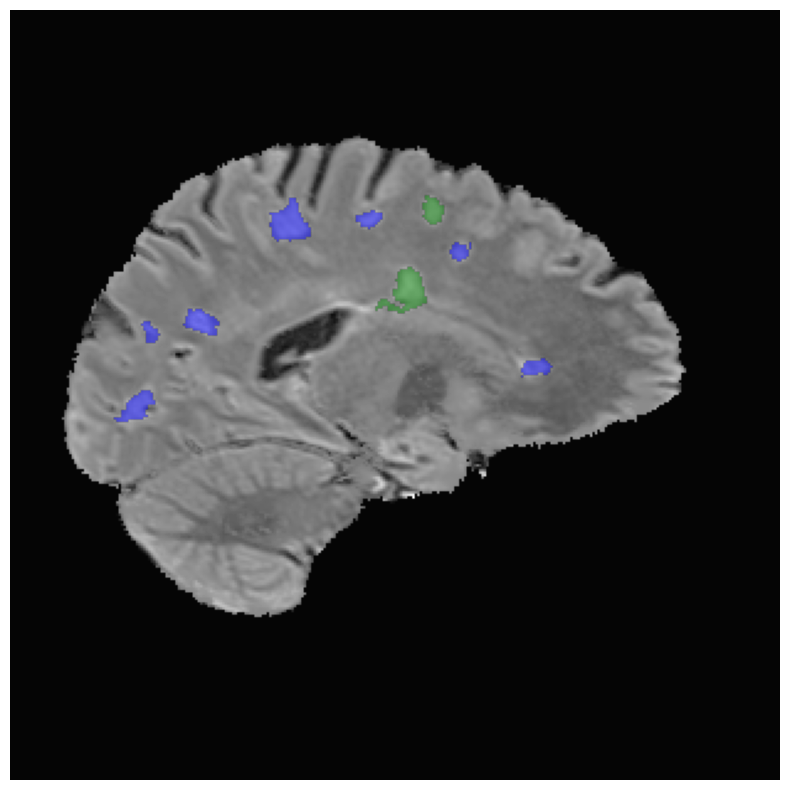

In [14]:
plt.close('all')
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 10))
#visualization.plot_nifti_on_ax(axs, img = mag[example_idx]) # T2 FLAIR magnitude
#visualization.plot_nifti_on_ax(axs, img = phase[example_idx]) # T2* phase
# visualization.plot_nifti_on_ax(axs, img = phase_mask[example_idx]) # T2* mask
#visualization.plot_nifti_on_ax(axs, img = flair_s[example_idx]) # SWI
visualization.plot_nifti_on_ax(axs, img = flair_s[example_idx], mask = mask[:, example_idx], drop_first_label_channel=False) # SWI with mask

plt.savefig("output/images/swi_creation_swi_masked.pdf", bbox_inches='tight')

In [15]:
CREATE_SWI_DATASET = False
if CREATE_SWI_DATASET:

    patient_dirs = [os.path.join(ORIG_PATH, p) for p in os.listdir(ORIG_PATH)]
    
    star.create_star_dataset(
        patient_dirs = patient_dirs,
        flair_fname=FLAIR,
        phase_fname=PHASE,
        lesion_fname=SEG_2_PHASE,
        prl_fname=PHASE_UNWRAPPED_UBMASK,
        save_train_val_dir=DIR_TRAIN_SWI_DATASET,
        save_test_dir=DIR_TEST_SWI_DATASET,
        num_test_samples=2,
        crop = SpatialCrop(roi_center = (256 // 2, 312 // 2, 312 // 2 - 50), roi_size = (256 - 64, 304, 304)), #Found by visual inspection
        augment_prl=True,
        high_pass_kernel_size=None,
    )

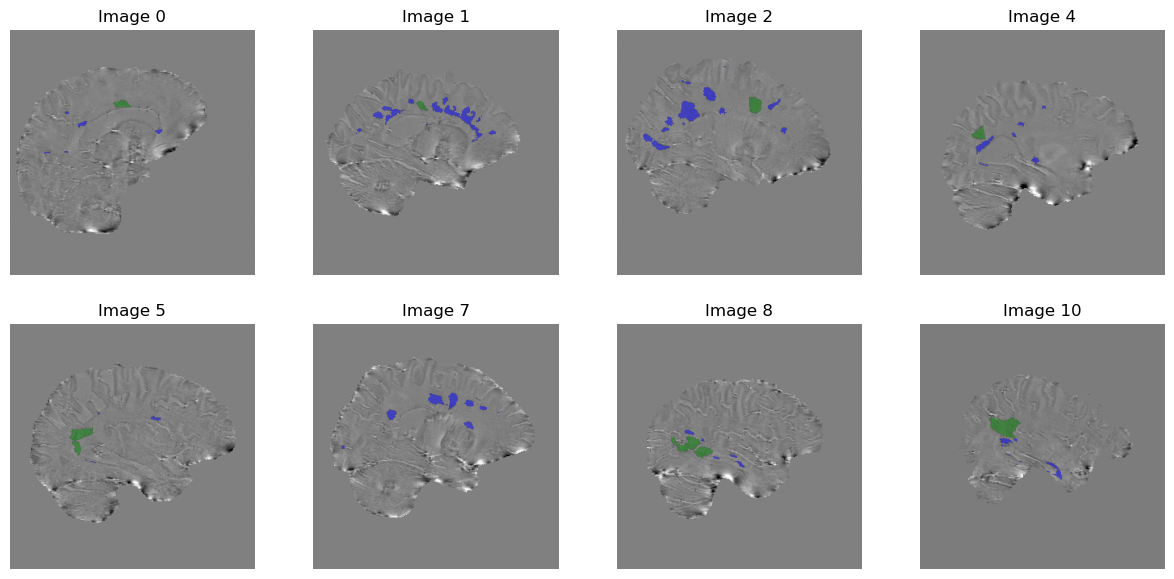

In [16]:
train_star_data = LazyDataset(DIR_TRAIN_SWI_DATASET)

n_rows = 2
n_cols = 4
example_idx = 70

plt.close('all')
fig, axs = plt.subplots(ncols = n_cols, nrows = n_rows, figsize = (15, 7))
for i, (idx, ax) in enumerate( zip(np.linspace(0, len(train_star_data)-1, n_rows * n_cols, dtype=int), axs.flatten())):
    img, phase, mask = train_star_data[idx]
    #ax.imshow(img.numpy(), cmap='gray')
    visualization.plot_nifti_on_ax(ax, img = phase[example_idx, 0], mask=mask[example_idx], drop_first_label_channel=True, title = f"Image {idx}")

In [17]:
net = unet.PRLUNet(n_channels=1, n_classes=2)

ok = net(train_star_data[0][0][0].unsqueeze(0), train_star_data[0][1][0].unsqueeze(0))

torch.Size([1, 1024, 19, 19]) torch.Size([1, 1024, 19, 19])


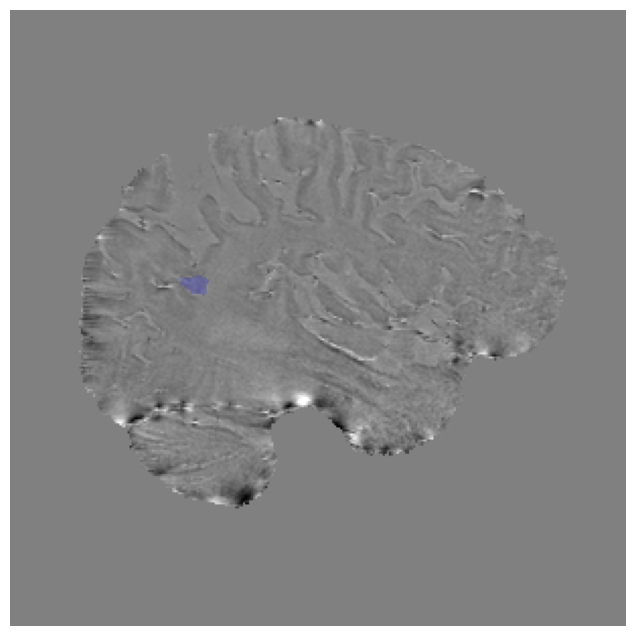

In [18]:
plt.close('all')
example_idx = 20
img, phase, mask = train_star_data[5]
fig, axs = plt.subplots(ncols = 1,nrows=1, figsize = (8, 8))

#visualization.plot_nifti_on_ax(axs, img = phase[example_idx, 0],  drop_first_label_channel=False)
visualization.plot_nifti_on_ax(axs, img = phase[example_idx, 0], mask = mask[example_idx, 2], drop_first_label_channel=False, alpha_mask = 0.2)
fig.savefig("output/images/prl_on_phase.pdf", bbox_inches='tight')


## x - Wasserstein distance

In [19]:
#all_labels_arr = torch.stack([label for _, label in train_star_data])

In [20]:
# observations_class_0 = torch.sum(all_labels_arr[:, 0].flatten(1, 3), dim=0)
# observations_class_1 = torch.sum(all_labels_arr[:, 1].flatten(1, 3), dim=0)
# observations_class_2 = torch.sum(all_labels_arr[:, 2].flatten(1, 3), dim=0)

# print(observations_class_0.shape, observations_class_1.shape, observations_class_2.shape)

# wasserstein_0_1 = wasserstein_distance(observations_class_0, observations_class_1)
# wasserstein_0_2 = wasserstein_distance(observations_class_0, observations_class_2)
# wasserstein_1_2 = wasserstein_distance(observations_class_1, observations_class_2)
# print(f"Wasserstein distance: {wasserstein_0_1}, {wasserstein_0_2}, {wasserstein_1_2}")

# 4 - Model

## 4.1 - UNet

# 5 - Training

# 6 - Evaluation

In [21]:
def vis_swi_pred(model, dataset: TensorDataset, example_batch_idx: int = 0, save_path: str = None):

    mag, phase, label = dataset[example_batch_idx]
    output = model(mag.unsqueeze(0), phase.unsqueeze(0))
    output = output.squeeze().detach()
    output = torch.sigmoid(output)
    output = output > 0.5

    mag = mag.squeeze(0)


    plt.close('all')
    fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 10))
    visualization.plot_nifti_on_ax(axs[0], img = mag, title = "SWI image")
    visualization.plot_nifti_on_ax(axs[1], img = mag, mask=label, title = "Target Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
    visualization.plot_nifti_on_ax(axs[2], img = mag, mask=output, title = "Predicted Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [22]:
lr = 2e-4
val_pred_data = torch.load(f"output/prl_unet_lr_{lr}_last_epoch_val.pt", weights_only=False)

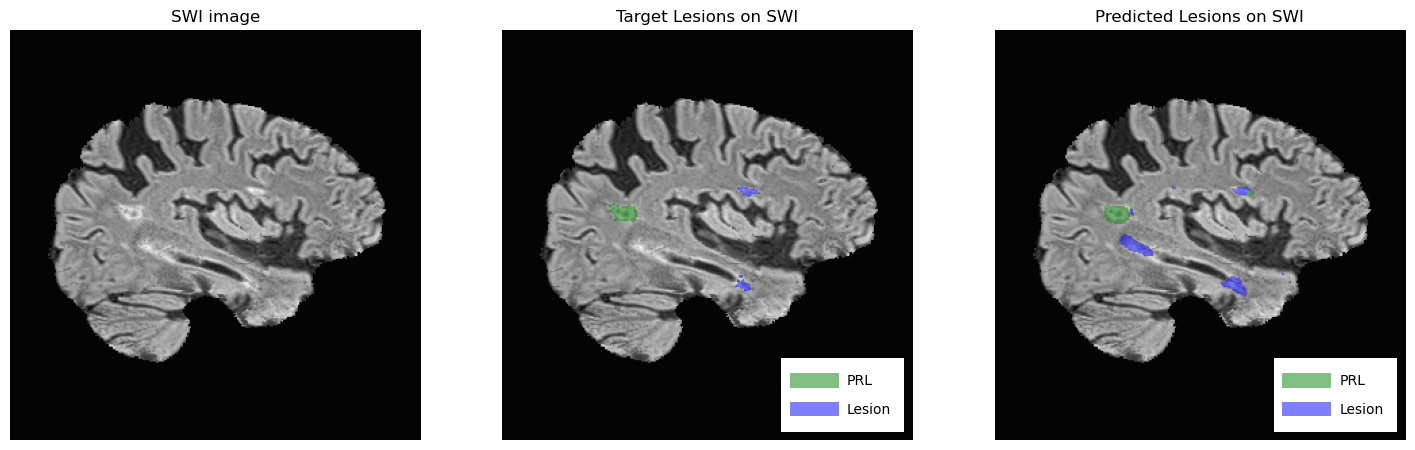

In [23]:
example_idx = 170
mag, phase, pred, label = val_pred_data[example_idx]
mag = mag.squeeze(0)
phase = phase.squeeze(0)

plt.close('all')
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 10))
visualization.plot_nifti_on_ax(axs[0], img = mag, title = "SWI image")
visualization.plot_nifti_on_ax(axs[1], img = mag, mask=label, title = "Target Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
visualization.plot_nifti_on_ax(axs[2], img = mag, mask=pred, title = "Predicted Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
plt.show()

In [24]:
all_labels_val = [label for _, _, _, label in val_pred_data]
all_preds_val = [pred for _, _, pred, _ in val_pred_data]

In [25]:
true_positive, false_positive, false_negative = evaluation.lesion_wise_tp_fp_fn(all_labels_val, all_preds_val, channel = 1, threshold=0.5, min_inter_lesion_distance=5)
print("Non-PRL lesions")
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")

Non-PRL lesions
True positive: 751, False positive: 1182, False negative: 9
F1 score: 0.55774229483847


In [26]:
print("PRL lesions")
true_positive, false_positive, false_negative = evaluation.lesion_wise_tp_fp_fn(all_labels_val, all_preds_val, channel = 2, threshold=0.1, min_inter_lesion_distance=10)
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")

PRL lesions
True positive: 214, False positive: 301, False negative: 1
F1 score: 0.5863013698630137


In [27]:
test_pred_data = torch.load(f"output/prl_unet_lr_{lr}_last_epoch_test.pt", weights_only=False)

In [28]:
all_labels_test = [label for _, _, _, label in test_pred_data]
all_preds_test = [pred for _, _, pred, _ in test_pred_data]

In [29]:
print("Non-PRL lesions")
true_positive, false_positive, false_negative = evaluation.lesion_wise_tp_fp_fn(all_labels_test, all_preds_test, channel = 1, threshold=0.1, min_inter_lesion_distance=5)
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")

Non-PRL lesions
True positive: 244, False positive: 222, False negative: 0
F1 score: 0.6873239436619719


In [ ]:
print("PRL lesions")
true_positive, false_positive, false_negative = evaluation.lesion_wise_tp_fp_fn(all_labels_test, all_preds_test, channel = 2, threshold=0.9)  
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")

PRL lesions
True positive: 44, False positive: 35, False negative: 0
F1 score: 0.7154471544715447


In [31]:
print(evaluation.f1_from_tp_fp_fn(201, 344, 0))

0.5388739946380697


# 7 - References

* Lou, , Sati, P., Absinta, M., Clark, K., Dworkin, J. D., Valcarcel, A. M., Schindler, M. K., Reich, D. S., Sweeney, E. M., & Shinohara, R. T. (2020). Fully automated detection of paramagnetic rims in multiple sclerosis lesions on 3T susceptibility-based MR imaging. *bioRxiv*. https://doi.org/10.1101/2020.08.31.276238

* Dymerska, B., Eckstein, K., Bachrata, B., Siow, B., Trattnig, S., Shmueli, K., Robinson, S.D., (2020). Phase Unwrapping with a Rapid Opensource Minimum Spanning Tree AlgOrithm (ROMEO). Magnetic Resonance in Medicine. https://doi.org/10.1002/mrm.28563